In [16]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.0.1+cu117'

## 1. Data- preparing and loading

In [2]:
weight = 0.7
bias = 0.3

start = 0 
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(len(X), len(y))

50 50


#### Spliting data into test sets

In [3]:
# Ratio 80:20
X_train, y_train = X[:40], y[:40]
X_test, y_test = X[40:], y[40:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

40 40
10 10


In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train,
                     test_data=X_test, test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14});

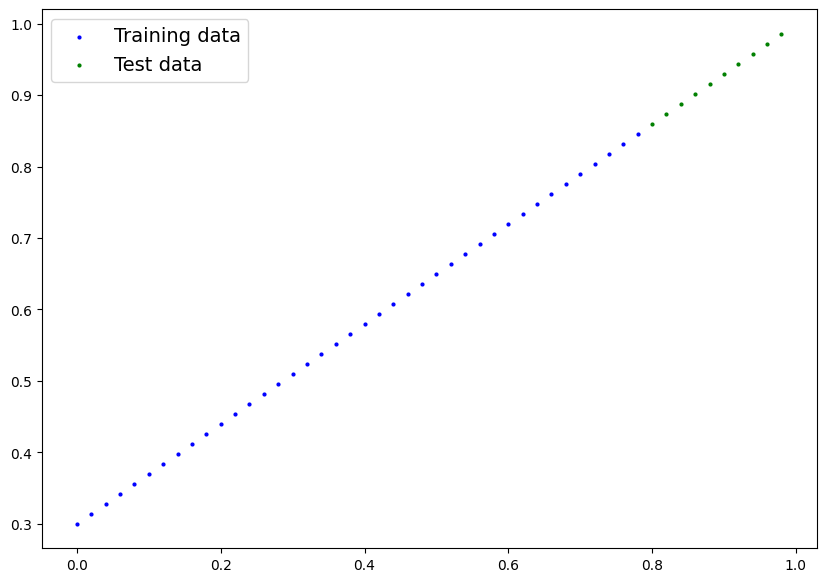

In [5]:
plot_predictions()

#### Building first pytorch model

Start with random values (weight, bias)  
Compare with training data and adjust this random values to better represent it  
```Gradient Descent and Backpropagation```

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
    # Model parameters
        self.weights = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1, dtype=torch.float))
    # Defines computations in model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # linear regression formula

    

In [7]:
torch.manual_seed(666)

model_0 = LinearRegressionModel()

model_0.state_dict()

OrderedDict([('weights', tensor([0.3119])), ('bias', tensor([0.2701]))])

In [8]:
with torch.inference_mode():
    y_pred = model_0(X_test)
y_pred

tensor([[0.5197],
        [0.5259],
        [0.5321],
        [0.5384],
        [0.5446],
        [0.5508],
        [0.5571],
        [0.5633],
        [0.5696],
        [0.5758]])

In [9]:
y_test


tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

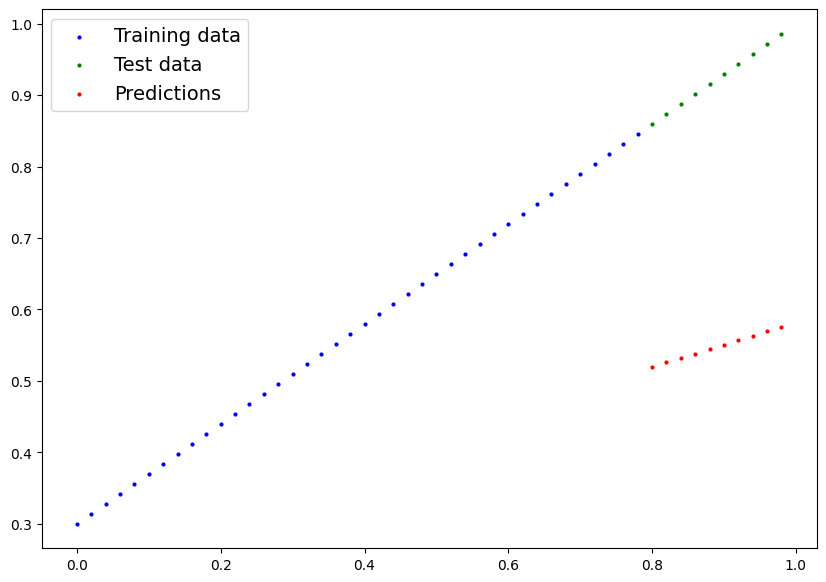

In [10]:
plot_predictions(predictions=y_pred)

In [11]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [12]:
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building training and testing loop

In [13]:
# epoch is one loop trough the data...
epochs = 200

# Tracking experiments
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train() # train mode in PyTorch sets all parameters that requires grad to require gradients
    # 1. Forward pass
    y_pred = model_0(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. Zero the optimizer's grad
    optimizer.zero_grad()
    # 4. Perform backpropagation on the loss
    loss.backward()
    # 5. Perform gradient descent
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        print(f"Epoch: {epoch} | Loss: {loss} | Test_loss: {test_loss}")
        print(model_0.state_dict(), "\n")


Epoch: 0 | Loss: 0.18122346699237823 | Test_loss: 0.3618006408214569
OrderedDict([('weights', tensor([0.3158])), ('bias', tensor([0.2801]))]) 

Epoch: 10 | Loss: 0.09322047978639603 | Test_loss: 0.24640055000782013
OrderedDict([('weights', tensor([0.3539])), ('bias', tensor([0.3616]))]) 

Epoch: 20 | Loss: 0.06662417948246002 | Test_loss: 0.18262360990047455
OrderedDict([('weights', tensor([0.3851])), ('bias', tensor([0.3976]))]) 

Epoch: 30 | Loss: 0.05871916562318802 | Test_loss: 0.14962129294872284
OrderedDict([('weights', tensor([0.4093])), ('bias', tensor([0.4091]))]) 

Epoch: 40 | Loss: 0.05454183742403984 | Test_loss: 0.1318390667438507
OrderedDict([('weights', tensor([0.4292])), ('bias', tensor([0.4091]))]) 

Epoch: 50 | Loss: 0.05105184391140938 | Test_loss: 0.12081898748874664
OrderedDict([('weights', tensor([0.4472])), ('bias', tensor([0.4041]))]) 

Epoch: 60 | Loss: 0.047574639320373535 | Test_loss: 0.11048581451177597
OrderedDict([('weights', tensor([0.4650])), ('bias', te

Text(0.5, 0, 'Epochs')

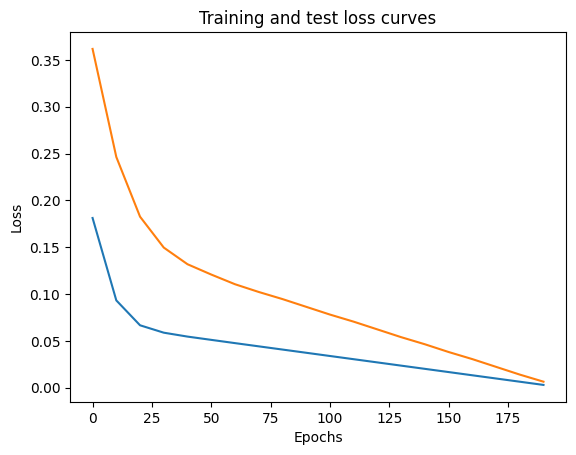

In [17]:
# Plot loss values:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")

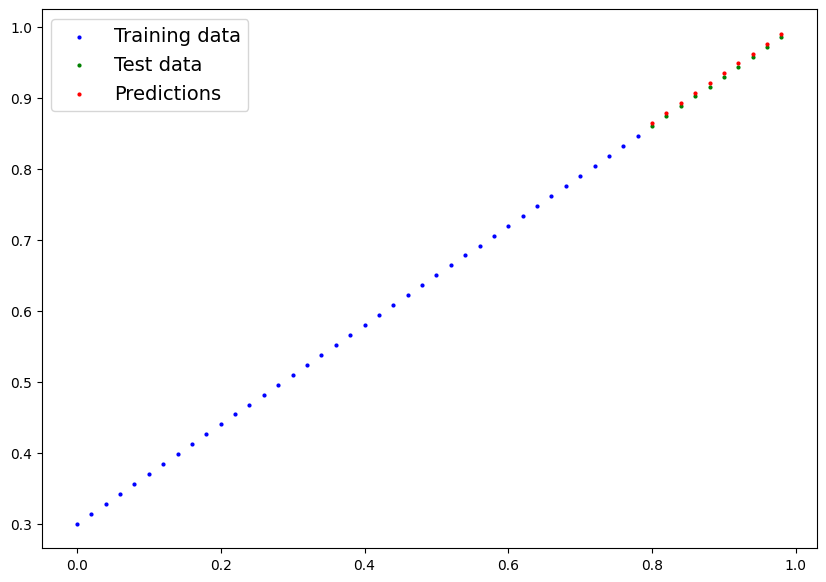

In [14]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch  

1. `torch.save()` allows to save PyTorch object in Pyhton's pickle format
2. `torch.load()` allows to load PyTorch objects
3. `torch.nn.Module.load_state_dict()` allows to load a models's state dictionary

In [20]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_01.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/model_01.pt


### Loading model back in

In [26]:
MODEL_LOAD_PATH = "models/model_01.pt"
loaded_model = torch.load(f=MODEL_LOAD_PATH)

test_model = LinearRegressionModel()
print(test_model.state_dict())


OrderedDict([('weights', tensor([0.1118])), ('bias', tensor([0.1012]))])


In [27]:
test_model.load_state_dict(loaded_model)

<All keys matched successfully>

In [28]:
print(test_model.state_dict())


OrderedDict([('weights', tensor([0.6956])), ('bias', tensor([0.3086]))])


### Making predictions with test model

In [29]:
test_model.eval()
with torch.inference_mode():
    test_model_y = test_model(X_test)
test_model_y

tensor([[0.8651],
        [0.8790],
        [0.8929],
        [0.9068],
        [0.9207],
        [0.9347],
        [0.9486],
        [0.9625],
        [0.9764],
        [0.9903]])

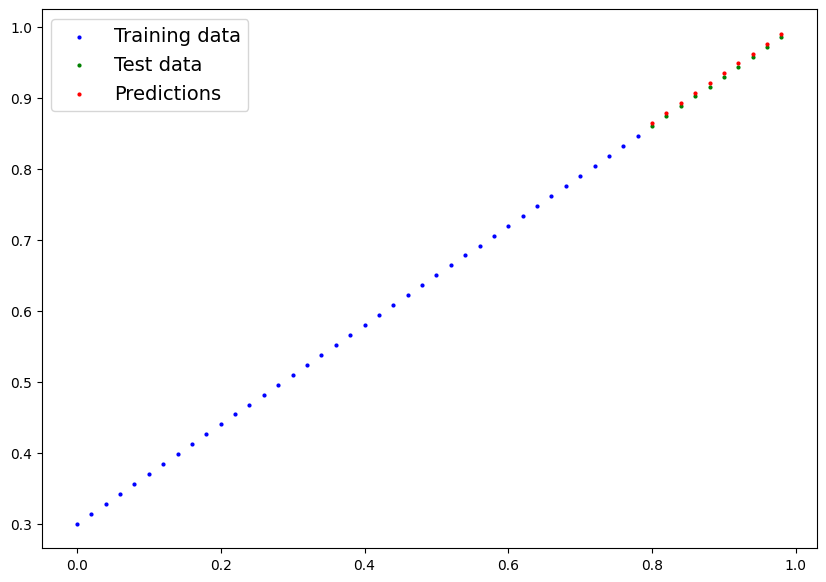

In [30]:
plot_predictions(predictions=test_model_y)

In [31]:
y_preds_new == test_model_y

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])